In [1]:
from __future__ import print_function, division
import os
import sys
import timeit

import numpy

import theano
import theano.tensor as T
from theano.sandbox.rng_mrg import MRG_RandomStreams

from logistic_sgd import LogisticRegression, load_data
from mlp import HiddenLayer
from rbm import RBM

Using gpu device 0: Tesla K80 (CNMeM is disabled)


In [2]:
%matplotlib inline
import matplotlib.pylab as plt

In [3]:
class DBN(object):
    """Deep Belief Network

    A deep belief network is obtained by stacking several RBMs on top of each
    other. The hidden layer of the RBM at layer `i` becomes the input of the
    RBM at layer `i+1`. The first layer RBM gets as input the input of the
    network, and the hidden layer of the last RBM represents the output. When
    used for classification, the DBN is treated as a MLP, by adding a logistic
    regression layer on top.
    """

    def __init__(self, numpy_rng, theano_rng=None, n_ins=784,
                 hidden_layers_sizes=[500, 500], n_outs=10):
        """This class is made to support a variable number of layers.

        :type numpy_rng: numpy.random.RandomState
        :param numpy_rng: numpy random number generator used to draw initial
                    weights

        :type theano_rng: theano.tensor.shared_randomstreams.RandomStreams
        :param theano_rng: Theano random generator; if None is given one is
                           generated based on a seed drawn from `rng`

        :type n_ins: int
        :param n_ins: dimension of the input to the DBN

        :type hidden_layers_sizes: list of ints
        :param hidden_layers_sizes: intermediate layers size, must contain
                               at least one value

        :type n_outs: int
        :param n_outs: dimension of the output of the network
        """

        self.sigmoid_layers = []
        self.rbm_layers = []
        self.params = []
        self.n_layers = len(hidden_layers_sizes)

        assert self.n_layers > 0

        if not theano_rng:
            theano_rng = MRG_RandomStreams(numpy_rng.randint(2 ** 30))

        # allocate symbolic variables for the data

        # the data is presented as rasterized images
        self.x = T.matrix('x')

        # the labels are presented as 1D vector of [int] labels
        self.y = T.ivector('y')
        # end-snippet-1
        # The DBN is an MLP, for which all weights of intermediate
        # layers are shared with a different RBM.  We will first
        # construct the DBN as a deep multilayer perceptron, and when
        # constructing each sigmoidal layer we also construct an RBM
        # that shares weights with that layer. During pretraining we
        # will train these RBMs (which will lead to chainging the
        # weights of the MLP as well) During finetuning we will finish
        # training the DBN by doing stochastic gradient descent on the
        # MLP.

        for i in range(self.n_layers):
            # construct the sigmoidal layer

            # the size of the input is either the number of hidden
            # units of the layer below or the input size if we are on
            # the first layer
            if i == 0:
                input_size = n_ins
            else:
                input_size = hidden_layers_sizes[i - 1]

            # the input to this layer is either the activation of the
            # hidden layer below or the input of the DBN if you are on
            # the first layer
            if i == 0:
                layer_input = self.x
            else:
                layer_input = self.sigmoid_layers[-1].output

            sigmoid_layer = HiddenLayer(rng=numpy_rng,
                                        input=layer_input,
                                        n_in=input_size,
                                        n_out=hidden_layers_sizes[i],
                                        activation=T.nnet.sigmoid)

            # add the layer to our list of layers
            self.sigmoid_layers.append(sigmoid_layer)

            # its arguably a philosophical question...  but we are
            # going to only declare that the parameters of the
            # sigmoid_layers are parameters of the DBN. The visible
            # biases in the RBM are parameters of those RBMs, but not
            # of the DBN.
            self.params.extend(sigmoid_layer.params)

            # Construct an RBM that shared weights with this layer
            rbm_layer = RBM(numpy_rng=numpy_rng,
                            theano_rng=theano_rng,
                            input=layer_input,
                            n_visible=input_size,
                            n_hidden=hidden_layers_sizes[i],
                            W=sigmoid_layer.W,
                            hbias=sigmoid_layer.b)
            self.rbm_layers.append(rbm_layer)

        # We now need to add a logistic layer on top of the MLP
        self.logLayer = LogisticRegression(
            input=self.sigmoid_layers[-1].output,
            n_in=hidden_layers_sizes[-1],
            n_out=n_outs)
        self.params.extend(self.logLayer.params)

        # compute the cost for second phase of training, defined as the
        # negative log likelihood of the logistic regression (output) layer
        self.finetune_cost = self.logLayer.negative_log_likelihood(self.y)

        # compute the gradients with respect to the model parameters
        # symbolic variable that points to the number of errors made on the
        # minibatch given by self.x and self.y
        self.errors = self.logLayer.errors(self.y)

    def pretraining_functions(self, train_set_x, batch_size, k):
        '''Generates a list of functions, for performing one step of
        gradient descent at a given layer. The function will require
        as input the minibatch index, and to train an RBM you just
        need to iterate, calling the corresponding function on all
        minibatch indexes.

        :type train_set_x: theano.tensor.TensorType
        :param train_set_x: Shared var. that contains all datapoints used
                            for training the RBM
        :type batch_size: int
        :param batch_size: size of a [mini]batch
        :param k: number of Gibbs steps to do in CD-k / PCD-k

        '''

        # index to a [mini]batch
        index = T.lscalar('index')  # index to a minibatch
        learning_rate = T.scalar('lr')  # learning rate to use

        # begining of a batch, given `index`
        batch_begin = index * batch_size
        # ending of a batch given `index`
        batch_end = batch_begin + batch_size

        pretrain_fns = []
        for rbm in self.rbm_layers:

            # get the cost and the updates list
            # using CD-k here (persisent=None) for training each RBM.
            # TODO: change cost function to reconstruction error
            cost, updates = rbm.get_cost_updates(learning_rate,
                                                 persistent=None, k=k)

            # compile the theano function
            fn = theano.function(
                inputs=[index, theano.In(learning_rate, value=0.1)],
                outputs=cost,
                updates=updates,
                givens={
                    self.x: train_set_x[batch_begin:batch_end]
                }
            )
            # append `fn` to the list of functions
            pretrain_fns.append(fn)

        return pretrain_fns

    def build_finetune_functions(self, datasets, batch_size, learning_rate):
        '''Generates a function `train` that implements one step of
        finetuning, a function `validate` that computes the error on a
        batch from the validation set, and a function `test` that
        computes the error on a batch from the testing set

        :type datasets: list of pairs of theano.tensor.TensorType
        :param datasets: It is a list that contain all the datasets;
                        the has to contain three pairs, `train`,
                        `valid`, `test` in this order, where each pair
                        is formed of two Theano variables, one for the
                        datapoints, the other for the labels
        :type batch_size: int
        :param batch_size: size of a minibatch
        :type learning_rate: float
        :param learning_rate: learning rate used during finetune stage

        '''

        (train_set_x, train_set_y) = datasets[0]
        (valid_set_x, valid_set_y) = datasets[1]
        (test_set_x, test_set_y) = datasets[2]

        # compute number of minibatches for training, validation and testing
        n_valid_batches = valid_set_x.get_value(borrow=True).shape[0]
        n_valid_batches //= batch_size
        n_test_batches = test_set_x.get_value(borrow=True).shape[0]
        n_test_batches //= batch_size

        index = T.lscalar('index')  # index to a [mini]batch

        # compute the gradients with respect to the model parameters
        gparams = T.grad(self.finetune_cost, self.params)

        # compute list of fine-tuning updates
        updates = []
        for param, gparam in zip(self.params, gparams):
            updates.append((param, param - gparam * learning_rate))

        train_fn = theano.function(
            inputs=[index],
            outputs=self.finetune_cost,
            updates=updates,
            givens={
                self.x: train_set_x[
                    index * batch_size: (index + 1) * batch_size
                ],
                self.y: train_set_y[
                    index * batch_size: (index + 1) * batch_size
                ]
            }
        )

        test_score_i = theano.function(
            [index],
            self.errors,
            givens={
                self.x: test_set_x[
                    index * batch_size: (index + 1) * batch_size
                ],
                self.y: test_set_y[
                    index * batch_size: (index + 1) * batch_size
                ]
            }
        )

        valid_score_i = theano.function(
            [index],
            self.errors,
            givens={
                self.x: valid_set_x[
                    index * batch_size: (index + 1) * batch_size
                ],
                self.y: valid_set_y[
                    index * batch_size: (index + 1) * batch_size
                ]
            }
        )

        # Create a function that scans the entire validation set
        def valid_score():
            return [valid_score_i(i) for i in range(n_valid_batches)]

        # Create a function that scans the entire test set
        def test_score():
            return [test_score_i(i) for i in range(n_test_batches)]

        return train_fn, valid_score, test_score

In [4]:
def test_DBN(finetune_lr=0.1, pretraining_epochs=100,
             pretrain_lr=0.01, k=1, training_epochs=1000,
             dataset='mnist.pkl.gz', batch_size=10):
    """
    Demonstrates how to train and test a Deep Belief Network.

    This is demonstrated on MNIST.

    :type finetune_lr: float
    :param finetune_lr: learning rate used in the finetune stage
    :type pretraining_epochs: int
    :param pretraining_epochs: number of epoch to do pretraining
    :type pretrain_lr: float
    :param pretrain_lr: learning rate to be used during pre-training
    :type k: int
    :param k: number of Gibbs steps in CD/PCD
    :type training_epochs: int
    :param training_epochs: maximal number of iterations ot run the optimizer
    :type dataset: string
    :param dataset: path the the pickled dataset
    :type batch_size: int
    :param batch_size: the size of a minibatch
    """

    datasets = load_data(dataset)

    train_set_x, train_set_y = datasets[0]
    valid_set_x, valid_set_y = datasets[1]
    test_set_x, test_set_y = datasets[2]

    # compute number of minibatches for training, validation and testing
    n_train_batches = train_set_x.get_value(borrow=True).shape[0] // batch_size

    # numpy random generator
    numpy_rng = numpy.random.RandomState(123)
    print('... building the model')
    # construct the Deep Belief Network
    dbn = DBN(numpy_rng=numpy_rng, n_ins=28 * 28,
              hidden_layers_sizes=[1000, 500, 250, 100, 50],
              n_outs=10)

    # start-snippet-2
    #########################
    # PRETRAINING THE MODEL #
    #########################
    print('... getting the pretraining functions')
    pretraining_fns = dbn.pretraining_functions(train_set_x=train_set_x,
                                                batch_size=batch_size,
                                                k=k)

    print('... pre-training the model')
    start_time = timeit.default_timer()
    # Pre-train layer-wise
    for i in range(dbn.n_layers):
        # go through pretraining epochs
        for epoch in range(pretraining_epochs):
            # go through the training set
            c = []
            for batch_index in range(n_train_batches):
                c.append(pretraining_fns[i](index=batch_index,
                                            lr=pretrain_lr))
            print('Pre-training layer %i, epoch %d, cost ' % (i, epoch), end=' ')
            print(numpy.mean(c, dtype='float64'))

    end_time = timeit.default_timer()
    # end-snippet-2
    print('The pretraining code for file ' + 'os.path.split(__file__)[1]' +
          ' ran for %.2fm' % ((end_time - start_time) / 60.), file=sys.stderr)
    ########################
    # FINETUNING THE MODEL #
    ########################

    # get the training, validation and testing function for the model
    print('... getting the finetuning functions')
    train_fn, validate_model, test_model = dbn.build_finetune_functions(
        datasets=datasets,
        batch_size=batch_size,
        learning_rate=finetune_lr
    )

    print('... finetuning the model')
    # early-stopping parameters

    # look as this many examples regardless
    patience = 4 * n_train_batches

    # wait this much longer when a new best is found
    patience_increase = 2.

    # a relative improvement of this much is considered significant
    improvement_threshold = 0.995

    # go through this many minibatches before checking the network on
    # the validation set; in this case we check every epoch
    validation_frequency = min(n_train_batches, patience / 2)

    best_validation_loss = numpy.inf
    test_score = 0.
    start_time = timeit.default_timer()

    done_looping = False
    epoch = 0
    
    best_iter = -1
    while (epoch < training_epochs) and (not done_looping):
        epoch = epoch + 1
        for minibatch_index in range(n_train_batches):

            train_fn(minibatch_index)
            iter = (epoch - 1) * n_train_batches + minibatch_index

            if (iter + 1) % validation_frequency == 0:

                validation_losses = validate_model()
                this_validation_loss = numpy.mean(validation_losses, dtype='float64')
                print('epoch %i, minibatch %i/%i, validation error %f %%' % (
                    epoch,
                    minibatch_index + 1,
                    n_train_batches,
                    this_validation_loss * 100.
                    )
                )

                # if we got the best validation score until now
                if this_validation_loss < best_validation_loss:

                    # improve patience if loss improvement is good enough
                    if (this_validation_loss < best_validation_loss *
                            improvement_threshold):
                        patience = max(patience, iter * patience_increase)

                    # save best validation score and iteration number
                    best_validation_loss = this_validation_loss
                    best_iter = iter

                    # test it on the test set
                    test_losses = test_model()
                    test_score = numpy.mean(test_losses, dtype='float64')
                    print(('     epoch %i, minibatch %i/%i, test error of '
                           'best model %f %%') %
                          (epoch, minibatch_index + 1, n_train_batches,
                          test_score * 100.))

            if patience <= iter:
                done_looping = True
                break

    end_time = timeit.default_timer()
    '''print(('Optimization complete with best validation score of %f %%, '
           'obtained at iteration %i, '
           'with test performance %f %%'
           ) % (best_validation_loss * 100., best_iter + 1, test_score * 100.))
    print('The fine tuning code for file ' + 'os.path.split(__file__)[1]' +
          ' ran for %.2fm' % ((end_time - start_time) / 60.), file=sys.stderr)'''
    
    return dbn

In [5]:
dbn = test_DBN(finetune_lr=0.1, pretraining_epochs=1,
             pretrain_lr=0.01, k=1, training_epochs=0,
             dataset='../data/mnist.pkl.gz', batch_size=64)

... loading data
... building the model
... getting the pretraining functions
... pre-training the model
Pre-training layer 0, epoch 0, cost  -126.359804122
Pre-training layer 1, epoch 0, cost  -483.68597924
Pre-training layer 2, epoch 0, cost  -59.7212910329
Pre-training layer 3, epoch 0, cost  -131.719481328
Pre-training layer 4, epoch 0, cost  -20.4834991326
... getting the finetuning functions
... finetuning the model


The pretraining code for file os.path.split(__file__)[1] ran for 0.13m


In [6]:
train_set_x, train_set_y = load_data('../data/mnist.pkl.gz')[0]

... loading data


In [7]:
def upthendown(V, d1=True, d2=True):
    # UP
    if d1:
        H0 = dbn.rbm_layers[0].propup(V)[-1].eval()
        H1 = dbn.rbm_layers[1].propup(H0)[-1].eval()
        H2 = dbn.rbm_layers[2].propup(H1)[-1].eval()
        H3 = dbn.rbm_layers[3].propup(H2)[-1].eval()
        H4 = dbn.rbm_layers[4].propup(H3)[-1].eval()
    else:
        H0 = dbn.rbm_layers[0].sample_h_given_v(V)[-1].eval()
        H1 = dbn.rbm_layers[1].sample_h_given_v(H0)[-1].eval()
        H2 = dbn.rbm_layers[2].sample_h_given_v(H1)[-1].eval()
        H3 = dbn.rbm_layers[3].sample_h_given_v(H2)[-1].eval()
        H4 = dbn.rbm_layers[4].sample_h_given_v(H3)[-1].eval()
    # DOWN
    if d2: # DOWN deterministic
        H3d = dbn.rbm_layers[4].propdown(H4)[-1].eval()
        H2d = dbn.rbm_layers[3].propdown(H3d)[-1].eval()
        H1d = dbn.rbm_layers[2].propdown(H2d)[-1].eval()
        H0d = dbn.rbm_layers[1].propdown(H1d)[-1].eval()
        Vd = dbn.rbm_layers[0].propdown(H0d)[-1].eval()
    else: # DOWN stochastic
        H3d = dbn.rbm_layers[4].sample_v_given_h(H4)[-1].eval()
        H2d = dbn.rbm_layers[3].sample_v_given_h(H3d)[-1].eval()
        H1d = dbn.rbm_layers[2].sample_v_given_h(H2d)[-1].eval()
        H0d = dbn.rbm_layers[1].sample_v_given_h(H1d)[-1].eval()
        Vd = dbn.rbm_layers[0].sample_v_given_h(H0d)[-1].eval()
    return Vd

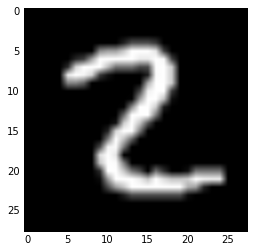

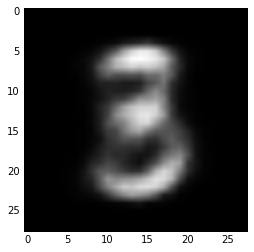

In [8]:
V = train_set_x.get_value()[76]
Vd = upthendown(V, True, True)

fig = plt.figure()
plt.imshow(V.reshape(28,28)*255., cmap=plt.cm.gray)
plt.show()
plt.imshow(Vd.reshape(28,28)*255., cmap=plt.cm.gray)
plt.show()